# NLP Lab6 - Named Entity Recognition

**Author: Bartłomiej Jamiołkowski**

The exercise shows how we may extract elements such as names of companies, countries and similar objects from text.

In [1]:
from datasets import load_dataset
from typing import Sequence
from collections import Counter
import spacy
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import warnings
warnings.filterwarnings('ignore')

## Tasks 1 - 2

Read the API of [NER](https://spacy.io/api/entityrecognizer) in Spacy

Take 1 thousand random passages from the FIQA-PL corpus.

In [2]:
fiqa_pl = load_dataset('clarin-knext/fiqa-pl', 'corpus')
fiqa_pl_df = fiqa_pl['corpus'].to_pandas()

In [3]:
random_passages_df = fiqa_pl_df.sample(n = 1000)
random_passages_df.head()

,_id,title,text
47702,495832,,">gdzie ekonomia keynesowska mówi, że nie ma po..."
52674,547866,,"Zadałem to pytanie w innym subskrypcie, ale po..."
8678,89519,,Zmagam się z 0% zainteresowania rzeczami w moi...
54515,567763,,"prawie wszystkie związki chcą, aby biznes, w k..."
42801,445461,,Transport naziemny limuzyny (Limo Mia GT) Limu...


## Task 3

Use the lemmatized and sentence split documents (using SpaCy API for [lemmatization](https://spacy.io/api/lemmatizer) and [sentence splitting](https://spacy.io/api/sentencizer)) to identify the expressions that consist of consecutive
   words starting with a capital letter (you will have to look at the inflected form of the word to check its
   capitalization) that do not occupy the first position in a sentence. E.g. the sentence:
   ```
   Wczoraj w Krakowie miało miejsce spotkanie prezydentów Polski i Stanów Zjednoczonych.
   ```
   should yield the following entries: `Kraków`, `Polska`, `Stan Zjednoczony`.

In [4]:
polish_nlp = spacy.load('pl_core_news_sm')

In [5]:
def identify_lemmatized_capitalized_expressions(textual_data: Sequence[str]) -> list:
    expressions = []
    expression = ''
    
    for passage in polish_nlp.pipe(textual_data):
        for sentence in passage.sents:
            for token in sentence[1:]:
                if token.text.istitle():
                    if expression:
                        expression += ' ' + token.lemma_
                    else:
                        expression = token.lemma_
                
                elif expression:
                    lemmatized_tokens = [expression_token.lemma_ for expression_token in polish_nlp(expression)]
                    
                    if all(lemmatized_token.istitle() for lemmatized_token in lemmatized_tokens):
                        expressions.append(expression)
                    
                    expression = ''

    return expressions

In [6]:
sentence = 'Wczoraj w Krakowie miało miejsce spotkanie prezydentów Polski i Stanów Zjednoczonych.'
print(f'Identified lemmatized capitalized expressions:{identify_lemmatized_capitalized_expressions([sentence])}')

Identified lemmatized capitalized expressions:['Kraków', 'Polska', 'Stany Zjednoczone']


## Task 4

Compute the frequency of each identified expression and print 50 results with the largest number of occurrences.

In [7]:
full_random_passages_text = ' '.join(random_passages_df['text'])

In [8]:
print(Counter(identify_lemmatized_capitalized_expressions([full_random_passages_text])).most_common(50))

[('Ciebie', 47), ('Roth', 45), ('Stany Zjednoczone', 28), ('K', 22), ('Google', 22), ('S&P', 21), ('Apple', 17), ('Indie', 17), ('Amazon', 16), ('Twojego', 16), ('Trump', 14), ('Twoją', 12), ('Twojej', 12), ('E', 12), ('B', 11), ('Internet', 10), ('Facebook', 9), ('Fed', 9), ('P', 9), ('Boeing', 9), ('Europa', 8), ('Miami', 7), ('Słowo', 7), ('Kalifornia', 7), ('S', 7), ('C', 7), ('Tesla', 7), ('Rosja', 7), ('Ameryka', 7), ('Yahoo', 7), ('Uber', 7), ('Limo Mia', 6), ('Cisco', 6), ('D', 6), ('Vanguard', 6), ('Oregon', 6), ('G', 6), ('Twoich', 5), ('Wikipedia', 5), ('Grecja', 5), ('Twitter', 5), ('China', 5), ('Rozszerzone', 5), ('Indianin', 5), ('Wall Street', 5), ('X', 5), ('Dubaj', 5), ('Rf', 5), ('Najważniejsze', 4), ('Pivot Point', 4)]


## Task 5

Apply the NER from SpaCy to identify the named entities in the same set of documents.

In [9]:
named_entities = [(entity.text, entity.label_) for entity in polish_nlp(full_random_passages_text).ents]
named_entities[:10]

[('keynesowska', 'placeName'),
 ('Paul Krugman', 'persName'),
 ('USA', 'placeName'),
 ('USA', 'placeName'),
 ('lipcu', 'date'),
 ('czerwcu', 'date'),
 ('latach 2010', 'date'),
 ('lipca 2011', 'date'),
 ('czerwca 2012', 'date'),
 ('lat 2010', 'date')]

## Task 6

Plot the frequency (histogram) of the identified classes.

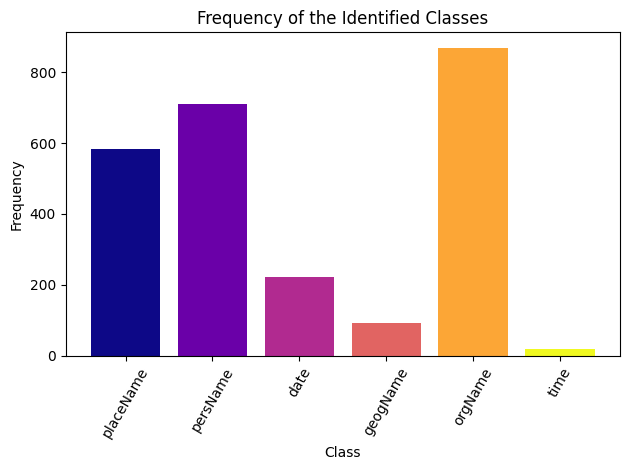

In [10]:
classes_counts = Counter([entity[1] for entity in named_entities])
colors = plt.cm.plasma(np.linspace(0, 1, len(classes_counts)))

plt.bar(classes_counts.keys(), classes_counts.values(), color = colors)
plt.xlabel('Class')
plt.ylabel('Frequency')
plt.title("Frequency of the Identified Classes")
plt.xticks(rotation = 60)
plt.tight_layout()
plt.show()

## Task 7

Display 10 most frequent Named Entities for each identified type.

In [11]:
def display_top_n_entities(n: int) -> None:
    top_n_entities_df = pd.DataFrame(columns = list(classes_counts.keys()))

    for entity_type in classes_counts.keys():
        entities_per_type = list(filter(lambda entity: entity[1] == entity_type, named_entities))
        entities_per_type = [entity[0] for entity in entities_per_type]
        entities_per_type_counts = list(Counter(entities_per_type).most_common(n))

        if len(entities_per_type_counts) != n:
            entities_per_type_counts += [np.nan] * (n - len(entities_per_type_counts))
        
        top_n_entities_df[entity_type] = entities_per_type_counts
    
    display(top_n_entities_df)

In [12]:
display_top_n_entities(10)

,placeName,persName,date,geogName,orgName,time
0,"(USA, 58)","(Amazon, 22)","(1099, 11)","(Europy, 4)","(IRA, 57)","(10, 2)"
1,"(Massachusetts, 17)","(OP, 9)","(1040, 8)","(europejski, 3)","(Google, 25)","(30, 2)"
2,"(Wielkiej Brytanii, 16)","(salda, 9)","(10., 5)","(Wall Street, 3)","(Apple, 19)","(23, 2)"
3,"(Stanach Zjednoczonych, 15)","(Trump, 9)","(lipcu, 4)","(Azji, 2)","(Roth IRA, 19)","(południa, 1)"
4,"(Kalifornii, 13)","(Fed, 8)","(2000 roku, 4)","(Tesli, 2)","(ETF, 16)","(16, 1)"
5,"(Indiach, 10)","(gdybyś, 7)","(2013 r., 4)","(Afryki, 2)","(IRS, 13)","(25, 1)"
6,"(amerykańskie, 9)","(Trumpa, 6)","(2013 roku, 4)","(Ziemia, 2)","(HSA, 13)","(55, 1)"
7,"(Stany Zjednoczone, 9)","(Ehrlich, 6)","(10 maja, 4)","(Europie, 2)","(Roth, 13)","(65, 1)"
8,"(amerykańskim, 8)","(Vanguard, 5)","(1116, 4)","(McDonald's, 2)","(GBP, 12)","(50, 1)"
9,"(Chiny, 8)","(McDonalds, 5)","(wrześniu, 3)","(Stafford, 2)","(UE, 10)","(12., 1)"


## Task 8

Display 50 most frequent Named Entities including their count and type.

In [13]:
top_50_named_entities = Counter([(entity.text, entity.label_) for entity in polish_nlp(full_random_passages_text).ents]).most_common(50)
top_50_named_entities

[(('USA', 'placeName'), 58),
 (('IRA', 'orgName'), 57),
 (('Google', 'orgName'), 25),
 (('Amazon', 'persName'), 22),
 (('Apple', 'orgName'), 19),
 (('Roth IRA', 'orgName'), 19),
 (('Massachusetts', 'placeName'), 17),
 (('Wielkiej Brytanii', 'placeName'), 16),
 (('ETF', 'orgName'), 16),
 (('Stanach Zjednoczonych', 'placeName'), 15),
 (('IRS', 'orgName'), 13),
 (('Kalifornii', 'placeName'), 13),
 (('HSA', 'orgName'), 13),
 (('Roth', 'orgName'), 13),
 (('GBP', 'orgName'), 12),
 (('1099', 'date'), 11),
 (('Indiach', 'placeName'), 10),
 (('UE', 'orgName'), 10),
 (('OP', 'persName'), 9),
 (('salda', 'persName'), 9),
 (('amerykańskie', 'placeName'), 9),
 (('Trump', 'persName'), 9),
 (('Stany Zjednoczone', 'placeName'), 9),
 (('1040', 'date'), 8),
 (('amerykańskim', 'placeName'), 8),
 (('Chiny', 'placeName'), 8),
 (('amerykańskich', 'placeName'), 8),
 (('Fed', 'persName'), 8),
 (('Nowy Jork', 'placeName'), 8),
 (('Miami', 'placeName'), 7),
 (('HMRC', 'orgName'), 7),
 (('gdybyś', 'persName'), 7

## Task 9

Display 5 sentences containing at least 2 recognized named entities with different types. Highlight the recognized spans with color.  (For demo application [Streamlit](https://streamlit.io/) might be useful for displaying NER results).

In [14]:
options = {'colors': dict(zip(classes_counts.keys(), [mcolors.to_hex(c) for c in sns.color_palette('Pastel2', n_colors = len(classes_counts.keys()))]))}

def display_sentences_with_many_entities(textual_data: Sequence[str], min_types: int, n: int) -> None:
    stop_search = False
    counter = 0
    
    for passage in textual_data:
        for sentence in polish_nlp(passage).sents:
            entity_types = set(entity.label_ for entity in sentence.ents)
                
            if len(entity_types) >= min_types:
                spacy.displacy.render(sentence, style = 'ent', options = options, jupyter = True)
                counter += 1

            if counter == n:
                stop_search = True
                break

        if stop_search:
            break

In [15]:
display_sentences_with_many_entities(random_passages_df['text'], 2, 5)

## Questions

### Question 1

Which of the method (counting expressions with capital letters vs. NER) worked better for the task concerned with identification of the proper names?

The NER method worked better for the task of identifying proper names. The obtained named entities were grouped, which made them easier to analyze. In contrast to the method of counting expressions with capital letters, it returned fewer examples that were not proper names e.g. 'Twojego', but they were too capitalized.

### Question 2

What are the drawbacks of the method based on capital letters?

The main disadvantage of the method based on capital letters is that it mistakenly identifies examples that are not named entities. This occurs in situations where the example is a polite phrase like 'Twojego.' What's more, if a named entity consists of lowercase characters, it can be split into two parts and therefore the original meaning is lost.

### Question 3

What are the drawbacks of the method based on NER?

The main disadvantage of the method based on NER is that it cannot deal with expressions with the same meaning, such as 'USA' and 'Stany Zjednoczone'. What's more, it incorrectly assigns expressions to classes.

### Question 4

Which of the coarse-grained NER groups has the best and which has the worst results? Try to justify this observation.

In my opinion, the obtained results do not allow me to draw conclusions without any doubts. By relying on the table created in task 7, I can say that the orgName group has the best results because all the provided names and shortcuts are indeed organization names. I suspect that there are so many organizations in the world identifying themselves with printed letters. On the other hand, there are groups with poor results, such as date or time, where NER could not distinguish between numbers, dates or times e.g. 1040 or 16 x 60.

### Question 5

Do you think NER is sufficient for identifying different occurrences of the same entity (i.e. consider "USA" and "Stany Zjednoczone" and "Stany Zjednoczone Ameryki Północnej")? If not, can you suggest an algorithm or a tool that would be able to group such names together?

In my opinion, NER is insufficient for identifying different occurrences of the same entity because it does not inherently resolve different mentions to the same canonical entity. In such situations, I would like to recommend a tool called Named Entity Linking (NEL) that can group such names together. NEL extends NER by linking recognized entities to a knowledge base, for example by extending the spaCy pipeline with NEL or using other libraries.

### Question 6

Can you think of a real world problem that would benefit the most from application of Named Entity Recognition algorithm?

From my perspective, Named Entity Recognition (NER) could be highly beneficial in trading, with numerous applications to consider. For example, NER could be combined with sentiment analysis to gauge market sentiment for specific companies or sectors. A case in point would be identifying negative sentiment about a company’s product, which could impact its stock price.

Another idea is using NER to detect events that can serve as trading signals. Imagine an article about an upcoming natural disaster in an area where oil wells are located. A trading algorithm could interpret this information and generate a signal to anticipate market movements based on the potential impact on oil production and price.
.


